In [1]:
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Variable to set how many files to read
num_files_to_read = 120  # Set the number of files to read (adjust as needed)
file_names = [f"./dataset/data_log_{i}.csv" for i in range(num_files_to_read)]

# Columns definition
columns = [
    "nome", "codigo", "tipo", "last_read", "nivel_rio", "nivel_rio_historico",
    "chuva_001h", "chuva_003h", "chuva_006h", "chuva_012h", "chuva_024h",
    "chuva_048h", "chuva_072h", "chuva_096h", "chuva_120h", "chuva_144h",
    "chuva_168h", "temp_atual", "temp_sens", "umidade", "vel_vento",
    "dir_vento", "pres_atmos", "nivel_montante", "nivel_jusante",
    "porc_reservatorio", "comp_abertas", "comp_fechadas", "__typename",
    "localizacao.lat", "localizacao.lng", "localizacao.__typename", "timestamp"
]

# Load CSV files with error handling
dfs = []
for file in file_names:
    try:
        df = pd.read_csv(file, names=columns, header=0)  # Skip the header row in all files
        dfs.append(df)
        print(f"Successfully loaded {file}")
    except FileNotFoundError:
        print(f"Error: {file} not found.")
    except pd.errors.ParserError:
        print(f"Error: Unable to parse {file}.")
    except Exception as e:
        print(f"Error reading {file}: {e}")

if len(dfs) == 0:
    raise Exception("No valid files were loaded. Please check the file paths or file content.")


Successfully loaded ./dataset/data_log_0.csv
Successfully loaded ./dataset/data_log_1.csv
Successfully loaded ./dataset/data_log_2.csv
Successfully loaded ./dataset/data_log_3.csv
Successfully loaded ./dataset/data_log_4.csv
Successfully loaded ./dataset/data_log_5.csv
Successfully loaded ./dataset/data_log_6.csv
Successfully loaded ./dataset/data_log_7.csv
Successfully loaded ./dataset/data_log_8.csv
Successfully loaded ./dataset/data_log_9.csv
Successfully loaded ./dataset/data_log_10.csv
Successfully loaded ./dataset/data_log_11.csv
Successfully loaded ./dataset/data_log_12.csv
Successfully loaded ./dataset/data_log_13.csv
Successfully loaded ./dataset/data_log_14.csv
Successfully loaded ./dataset/data_log_15.csv
Successfully loaded ./dataset/data_log_16.csv
Successfully loaded ./dataset/data_log_17.csv
Successfully loaded ./dataset/data_log_18.csv
Successfully loaded ./dataset/data_log_19.csv
Successfully loaded ./dataset/data_log_20.csv
Successfully loaded ./dataset/data_log_21.cs

In [2]:
# Concatenate all DataFrames
data = pd.concat(dfs)

# Filter data for the selected stations
stations = ['DCSC Brusque', 'DCSC Vidal Ramos']
filtered_data = data[data['nome'].isin(stations)]

# Pivot data to have separate columns for each station's data
pivoted_data = filtered_data.pivot_table(index="timestamp", columns="nome", values=["nivel_rio", "chuva_024h"])
pivoted_data.columns = ['nivel_rio_brusque', 'nivel_rio_vidal_ramos', 'chuva_024h_brusque', 'chuva_024h_vidal_ramos']
pivoted_data.reset_index(inplace=True)
pivoted_data.sort_values(by="timestamp", inplace=True)

# Create lagged features
pivoted_data['nivel_rio_brusque_lag1'] = pivoted_data['nivel_rio_brusque'].shift(1)
pivoted_data['nivel_rio_vidal_ramos_lag1'] = pivoted_data['nivel_rio_vidal_ramos'].shift(1)
pivoted_data['chuva_024h_brusque_lag1'] = pivoted_data['chuva_024h_brusque'].shift(1)
pivoted_data['chuva_024h_vidal_ramos_lag1'] = pivoted_data['chuva_024h_vidal_ramos'].shift(1)

# Create the target variable (next day's river level in Brusque)
pivoted_data['nivel_rio_brusque_next_day'] = pivoted_data['nivel_rio_brusque'].shift(-1)

# Drop missing values
pivoted_data = pivoted_data.dropna()

In [3]:
# Prepare features and target
X = pivoted_data[['nivel_rio_brusque_lag1', 'nivel_rio_vidal_ramos_lag1', 'chuva_024h_brusque_lag1', 'chuva_024h_vidal_ramos_lag1']]
y = pivoted_data['nivel_rio_brusque_next_day']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
# Train a Random Forest Regressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.4f}')

Mean Squared Error: 0.5044


In [5]:
# Display last 5 predictions for validation
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).tail(5)
print("\nLast 5 Predictions:\n", comparison)



Last 5 Predictions:
        Actual  Predicted
17227    0.00       0.00
21251    0.00       0.00
12268    0.50       0.50
18517   12.42      12.42
15424    0.38       0.38


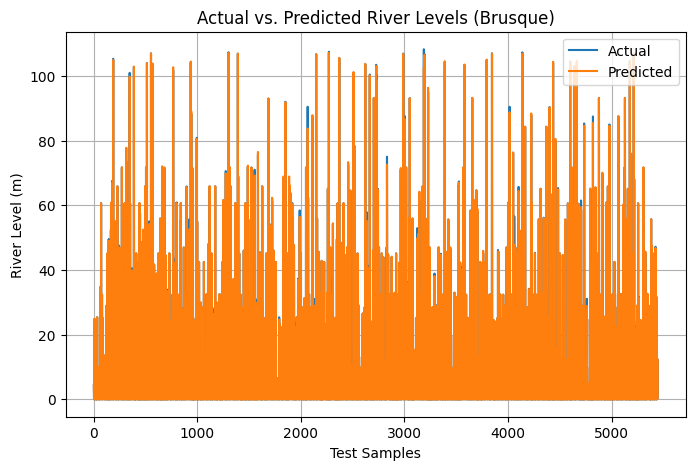

In [10]:
# Plot actual vs. predicted
%matplotlib inline
plt.figure(figsize=(8, 5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Actual vs. Predicted River Levels (Brusque)")
plt.xlabel("Test Samples")
plt.ylabel("River Level (m)")
plt.legend()
plt.grid()
plt.show()

In [7]:
# Improved Prediction Function
def predict_next_day_river_level(latest_data=None):
    """
    Predict the next day's river level for Brusque.
    
    Parameters:
    latest_data (list or None): If None, uses the last row of the test set.
                                Otherwise, provide a list [nivel_rio_brusque_lag1, nivel_rio_vidal_ramos_lag1, chuva_024h_brusque_lag1, chuva_024h_vidal_ramos_lag1].
    
    Returns:
    float: Predicted river level for the next day.
    """
    if latest_data is None:
        latest_data = X_test.iloc[-1].values
        print("Using the last test row for prediction:", latest_data)
    else:
        print("Using provided data for prediction:", latest_data)

    latest_data_df = pd.DataFrame([latest_data], columns=X.columns)
    return model.predict(latest_data_df)[0]

In [8]:
# Example: Predict using the last test set row
predicted_river_level = predict_next_day_river_level()
print(f"Predicted river level for the next day in Brusque: {predicted_river_level:.2f}")

Using the last test row for prediction: [0.38       0.02       1.28999996 1.64999998]
Predicted river level for the next day in Brusque: 0.38
